# Reference
https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/#gan-evaluation--the-frechet-inception-distance-and-inception-score-metrics

## Required Dependencies
Pytorch, Torchvision and Pytorch-Ignite are the required dependencies. They will be installed/imported here.

In [1]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 5.2 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 2.0.1+cu118
torchvision: 0.15.2+cu118
ignite: 0.4.12


## Import Libraries

Note: torchsummary is an optional dependency here.

In [3]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

In [4]:
ignite.utils.manual_seed(999)

## Processing Data

The [Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is used in this tutorial. The `torchvision` library provides a [dataset class](https://pytorch.org/vision/stable/datasets.html#celeba), However this implementation suffers from issues related to the download limitations of `gdrive`. Here, we define a custom `CelebA` [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).


In [6]:
from torchvision.datasets import ImageFolder

In [7]:
!gdown --id 1O8LE-FpN79Diu6aCvppH5HwlcR5I--PX
!mkdir data
!unzip -qq img_align_celeba.zip -d data

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O8LE-FpN79Diu6aCvppH5HwlcR5I--PX
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:15<00:00, 91.2MB/s]


### Dataset and transformation

The image size considered in this tutorial is `64`. Note that increase this size implies to modify the GAN models.

In [8]:
image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = ImageFolder(root="./data", transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))

### DataLoading

We wish to configure the dataloader to work in a disbtributed environment. Distributed Dataloading is support by Ignite as part of DDP support. This requires specific adjustments to the sequential case.

To handle this, `idist` provides an helper [`auto_dataloader`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_dataloader.html#auto-dataloader) which automatically distributes the data over the processes.

**Note**: Distributed dataloading is described in [Distributed Data Parallel (DDP)](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) tutorial if you wish to learn more.

In [9]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True,
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False,
    drop_last=True,
)

Let's explore the data.

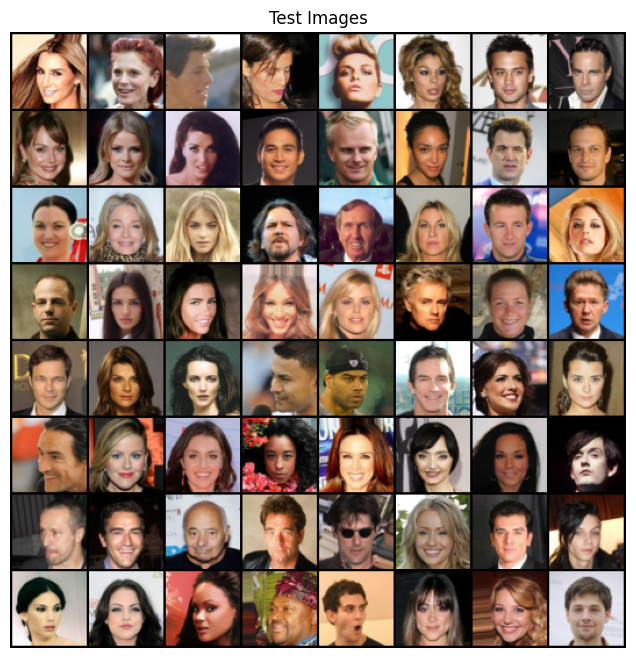

In [10]:
real_batch = next(iter(test_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

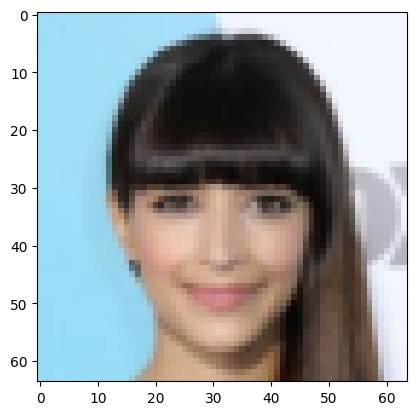

In [11]:
grid_ex = torchvision.utils.make_grid(real_batch[0][120], padding=2, normalize=True)
plt.imshow(grid_ex.permute(1,2,0))
plt.show

======================================================================================

## Evaluate model which you made.

Now let's generate images with the model we've created. First, we'll link the current file to Google Drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/final_project_solution

Mounted at /content/drive
/content/drive/MyDrive/final_project_solution


## Install openai-clip and import libraries that you need.

In [13]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368604 sha256=aefd8c6221529b67cea249d44d50c55d60f20fcc8f120165cea966445ae23edf
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [14]:
import warnings
warnings.filterwarnings(action="ignore")

import argparse
import click
import os
import torch
import torchvision
import clip
from fix_seed import seed_fix
from pathlib import Path
from network import Generator, Discriminator
from train_utils import *


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model, _ = clip.load(f"ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 114MiB/s]


## Input the prompt that you want to generate and the epoch number that you stop the training.

In [ ]:
text = str(input("Prompt : "))
load_epoch = int(str("Epoch we will load : "))

## Let's see the images that you generate.

In [16]:
# seed_fix(40)
hyp = torch.load(os.path.join('./model_exp1', f"hyperparameter.pt"), map_location='cpu')


G = Generator(hyp['clip_embedding_dim'], hyp['projection_dim'], hyp['noise_dim'], hyp['g_in_chans'], hyp['g_out_chans'], hyp['num_stage'], device).to(device)
D_lst = [
        Discriminator(hyp['projection_dim'], hyp['g_out_chans'], hyp['d_in_chans'], hyp['d_out_chans'], hyp['clip_embedding_dim'], curr_stage, device).to(device)
        for curr_stage in range(hyp['num_stage'])
    ]
load_checkpoint(G, D_lst, './model_exp1', load_epoch) # epoch 숫자 바꿔서 모델 쓸 것

prompt = clip.tokenize([text]).to(device)
txt_feature = clip_model.encode_text(prompt)
z = torch.randn(txt_feature.shape[0], hyp['noise_dim']).to(device)
txt_feature = normalize(txt_feature.to(device)).type(torch.float32)

fake_images, _, _ = G(txt_feature, z)
fake_image_64 = denormalize_image(fake_images[-3].detach().cpu())
fake_image_128 = denormalize_image(fake_images[-2].detach().cpu())
fake_image_256 = denormalize_image(fake_images[-1].detach().cpu())


<function matplotlib.pyplot.show(close=None, block=None)>

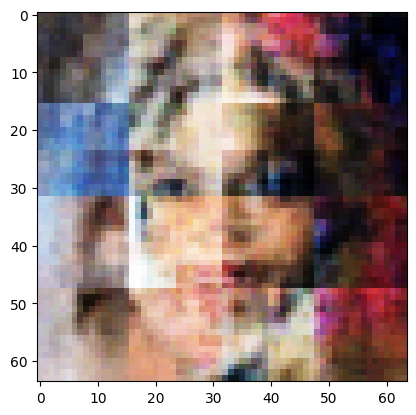

In [17]:
grid = torchvision.utils.make_grid(fake_image_64, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.show

## Generate several images for evaluation with test data, in the amount of the batch size.

In [18]:
def generate_images_batch(batch_size):
  fake_image_list = []
  for _ in range(batch_size):
    prompt = clip.tokenize([text]).to(device)
    txt_feature = clip_model.encode_text(prompt)
    z = torch.randn(txt_feature.shape[0], hyp['noise_dim']).to(device)
    txt_feature = normalize(txt_feature.to(device)).type(torch.float32)

    fake_images, _, _ = G(txt_feature, z)
    fake_image_64 = denormalize_image(fake_images[-3].detach().cpu())
    fake_image_list.append(fake_image_64.squeeze(0))
  fake_image_stacked = torch.stack(fake_image_list, dim=0)
  return fake_image_stacked

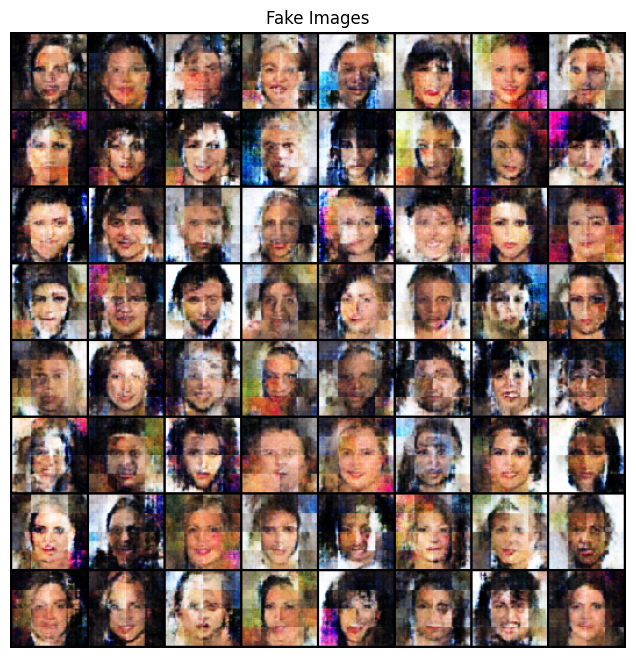

In [19]:
fake_batch = generate_images_batch(128)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [20]:
fake_batch.shape

torch.Size([128, 3, 64, 64])

## Let's measure FID and IS using the two prepared datasets.

In [21]:
from ignite.metrics import FID, InceptionScore

In [22]:
fid_metric = FID(device=idist.device())

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 74.7MB/s]


In [23]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [24]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [25]:
def evaluation_step(engine, batch):
    with torch.no_grad():
        fake_batch = generate_images_batch(128)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [26]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [27]:
evaluator.run(test_dataloader,max_epochs=1) # This code will take quite some time to execute.

State:
	iteration: 23
	epoch: 1
	epoch_length: 23
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [28]:
metrics = evaluator.state.metrics

In [29]:
fid_score = metrics['fid']
is_score = metrics['is']

In [30]:
print(f"*   FID : {fid_score:4f}")
print(f"*    IS : {is_score:4f}")

*   FID : 0.147612
*    IS : 2.127743
